In [1]:
%%capture
%load_ext autoreload
%autoreload 2
# This is the WORKING FILE
# Priority in the paper, TODO!: 1. include hydrogen, 2. adjust for capacity of fossils (notably gas), what has been done for renewables (Appendix A)
# TODO: 1. compute EROI from foreground (through supply, use unitary), 2. other definition of NEER (primary, decomposition), 3. storage & grid
# TODO: check err and errs
# most important things to do: 1. add new transport system; 2. EROI of biofuels?#         
# TODO: check si energy requirement from foreground correspond to Aversen et al. (2018), why do they say that market shares are unimportant in this paper?
# TODO!: compare EROI of THEMIS and exio2p, is there any background input in the foreground? quels sont 3 secteurs dans background themis absent de exio?
# TODO: steam & hot water in same category than gas??
# TODO: change name neer -> ger
# TODO: Demander à Thomas ou Anders le vecteur de demande finale d'élec par secteur (mail du 2/08)
# On ne peut pas appliquer GRAS car pour cela il faudrait connaître z (ou x ou y), l'idée étant de ne pas mettre le même mix pour tous secteurs,
#   et donc d'appliquer GRAS sur Z en prenant comme somme des colonnes les scénarios Greenpeace ou IEA. Sans ça, j'ai peur qu'on doive prendre le même mix pour
#   tous les secteurs.
# Lifetime & LCOE data in Supplementary info & mixes.xlsx
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 'last' 'none' ...

import pymrio
from pymrio.core.mriosystem import IOSystem as IOS
from pymrio.tools.iomath import div0
from pymrio.tools.ioparser import themis_parser
import pandas as pd
import numpy as np
import scipy
import scipy.sparse as sp 
from scipy.sparse import linalg as spla
import operator
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pickle
import os
import time

path_themis = '/media/adrien/dd1/adrien/DD/Économie/Données/Themis/'
path_io = '/media/adrien/dd1/adrien/DD/Économie/Données/'

In [2]:
themis = pymrio.themis_parser(path_themis)

/home/adrien/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [2]:
# themis, EROIs_mixes, dlr, EROIs_Mixes = pickle.load(open(path_io+'Themis/EROIs.pkl', 'rb'))
themis = pickle.load(open(path_io+'Themis/themis.pkl', 'rb'))
# themis = dict()
# for s in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']:
#     themis[s] = pickle.load(open(path_io+'Themis/themis_'+s+'.pkl', 'rb'))
erois_prices = pickle.load(open(path_io+'Themis/erois_prices.pkl', 'rb'))
erois_prices_wo_GW = pickle.load(open(path_io+'Themis/erois_prices_wo_GW.pkl', 'rb'))

In [10]:
"""
Diverse methods and functions to manipulate IOSystems, such as production of some sectors, their embodied impacts, inputs or EROI. 
Mostly developed for Exiobase 1 and 2, may not be compatible with other databases.
by adrien fabre (aka. bixiou on github), feel free to ask: adrien.fabre@psemail.eu
"""

from pymrio.core.mriosystem import IOSystem as IOS
from pymrio.tools.iomath import div0
from pymrio.tools.iomath import sorted_series
from pymrio.tools.iomath import approx_solution
import pandas as pd
import numpy as np
import scipy.sparse as sp 
from scipy.sparse import linalg as spla

def energy_sectors(self, notion): # TODO: other sectors, difference from elecs_names to add after elec and to display
    '''
    Returns the list of energy sectors (or names) corresponding to notion, which can be: secondary, secondary_fuels, elec_hydrocarbon, electricities,elecs_names
    '''
    if notion is None: sectors = self.sectors
    elif notion not in ['secondary', 'secondary_fuels', 'elec_hydrocarbon', 'electricities', 'elecs_names', 'secondary_heats', 'renewable', 'renew_names']:
        print('Error: notion unknown')
    elif notion=='elec_hydrocarbon': sectors = ['Electricity by coal', 'Electricity by gas']
    elif notion=='secondary_fuels': sectors = ['Motor Gasoline', 'Gas/Diesel Oil', 'Heavy Fuel Oil', 'Liquefied Petroleum Gases (LPG)', \
         'Naphtha', 'Non-specified Petroleum Products', 'Kerosene', 'Kerosene Type Jet Fuel', 'Petroleum Coke', 'Aviation Gasoline', 'Gasoline Type Jet Fuel']
    elif notion=='electricities': sectors = ['Electricity by ' + s for s in self.energy_sectors('elecs_names')]
    elif notion=='renewable': sectors = ['Electricity by ' + s for s in self.energy_sectors('renew_names')]
    elif notion=='secondary_heats': sectors = ['Steam and hot water supply services'] + self.energy_sectors('secondary_fuels')
        
    if self.name.lower()=='cecilia' or (self.name.lower()=='exiobase' and self.meta.version=='1'): 
        if notion=='secondary_fuels': sectors = ['Motor spirit (gasoline)', 'Gas oils', 'Fuel oils n.e.c.', 'Kerosene, including kerosene type jet fuel', \
                                                'Petroleum gases and other gaseous hydrocarbons, except natural gas']
        elif notion=='secondary': sectors = ['Electricity by hydro', 'Electricity nec, including biomass and waste', 'Steam and hot water supply services',
 'Electricity by nuclear', 'Electricity by coal', 'Electricity by gas', 'Motor spirit (gasoline)', 'Gas oils', 'Fuel oils n.e.c.', 'Electricity by wind', 
 'Kerosene, including kerosene type jet fuel', 'Petroleum gases and other gaseous hydrocarbons, except natural gas']
#  ['Coal and lignite; peat (10)', 'Natural gas and services related to natural gas extraction, excluding surveying', 'Nuclear fuel', 'Motor spirit (gasoline)',
#         'Gas oils', 'Fuel oils n.e.c.', 'Kerosene, including kerosene type jet fuel', 'Petroleum gases and other gaseous hydrocarbons, except natural gas']
        elif notion=='elecs_names': 
            sectors = ['wind', 'hydro', 'coal', 'gas', 'nuclear']

    elif self.name.lower()=='exiobase' and self.meta.version[0]=='2':
        if notion=='elec_hydrocarbon': sectors = sectors + ['Electricity by petroleum and other oil derivatives']
        elif notion=='secondary_fuels': sectors = ['Aviation Gasoline', 'Gas/Diesel Oil', 'Gasoline Type Jet Fuel', 'Heavy Fuel Oil', 'Kerosene', \
     'Kerosene Type Jet Fuel', 'Liquefied Petroleum Gases (LPG)', 'Motor Gasoline', 'Naphtha', 'Non-specified Petroleum Products', 'Petroleum Coke'] #TODO:check
        elif notion=='secondary': sectors =['Steam and hot water supply services', 'Electricity by petroleum and other oil derivatives',
 'Electricity by hydro', 'Electricity by wind', 'Electricity by biomass and waste', 'Electricity by tide, wave, ocean',
 'Electricity by Geothermal', 'Electricity by solar photovoltaic', 'Electricity by solar thermal', 'Electricity by coal', 'Electricity by gas',
 'Electricity by nuclear', 'Electricity nec', 'Motor Gasoline', 'Gas/Diesel Oil', 'Heavy Fuel Oil', 'Kerosene Type Jet Fuel',
 'Liquefied Petroleum Gases (LPG)', 'Naphtha', 'Non-specified Petroleum Products', 'Kerosene', 'Petroleum Coke', 'Aviation Gasoline', 'Gasoline Type Jet Fuel']
#             ['Other Bituminous Coal', 'Coking Coal', 'Lignite/Brown Coal', 'Sub-Bituminous Coal', 'Anthracite', \
#  'Natural gas and services related to natural gas extraction, excluding surveying', 'Nuclear fuel', 'Biogas', 'Biodiesels', 'Charcoal', 'Ethane', \
#  'Gas Coke', 'Gas Works Gas', 'Other Hydrocarbons', 'Other Liquid Biofuels', 'Motor Gasoline', 'Gas/Diesel Oil', 'Heavy Fuel Oil', 'Kerosene Type Jet Fuel', \
#  'Liquefied Petroleum Gases (LPG)', 'Naphtha', 'Non-specified Petroleum Products', 'Kerosene','Petroleum Coke', 'Aviation Gasoline', 'Gasoline Type Jet Fuel']
        elif notion=='elecs_names': sectors = ['wind', 'solar photovoltaic', 'coal', 'petroleum and other oil derivatives', 'gas', 'nuclear', 'hydro']

    elif self.name.lower()=='themis':
        if notion=='elec_hydrocarbon': sectors = sectors + ['Electricity by oil']
        elif notion=='secondary': sectors = ['Steam and hot water supply services', 'Electricity by hydro', 'Electricity by wind onshore',\
                 'Electricity by wind offshore', 'Electricity by biomass&Waste', 'Electricity by ocean', 'Electricity by geothermal', \
                 'Electricity by solar PV', 'Electricity by solar CSP', 'Electricity by coal', 'Electricity by gas', 'Electricity by oil', \
                 'Electricity by nuclear', 'Motor Gasoline', 'Gas/Diesel Oil', 'Heavy Fuel Oil', 'Kerosene Type Jet Fuel', 'Liquefied Petroleum Gases (LPG)', \
                'Naphtha', 'Non-specified Petroleum Products', 'Kerosene', 'Petroleum Coke', 'Aviation Gasoline', 'Gasoline Type Jet Fuel']
        elif notion=='elecs_names': sectors = ['wind onshore', 'wind offshore', 'solar PV', 'coal', 'oil', 'gas', 'nuclear', 'hydro', 'coal w CCS', \
                                               'gas w CCS', 'biomass&Waste', 'biomass w CCS', 'ocean', 'geothermal', 'solar CSP']
        elif notion=='renew_names': sectors = ['wind onshore', 'wind offshore', 'solar PV', 'hydro', 'biomass&Waste', 'biomass w CCS', \
                                             'ocean', 'geothermal', 'solar CSP']
    else: print('Function not yet implemented for this IOSystem')
    return(sectors)

@property
def regions(self): 
    '''
    Returns the list of all regions in the IOSystem
    '''
    if self.name == 'THEMIS' or self.name == 'Cecilia': return(self.labels.regions)
    else: return(list(self.get_regions())) 

@property
def sectors(self): 
    '''
    Returns the list of all sectors in the IOSystem
    '''
    if self.name == 'THEMIS' or self.name == 'Cecilia': return(self.labels.sectors)
    else: return(list(self.get_sectors()))

def prepare_secs_regs(self, secs, regs):
    '''
    Prepare the values by default of secs and regs for many methods: all sectors and all regions of the IOSystem.
    '''
    if secs is None: secs = self.sectors
    elif type(secs)==str: secs=[secs]
    if regs is None: regs = self.regions # regions bugs with impacts ... [reg, secs]
    elif type(regs)==str: regs=[regs]
    return((secs, regs))

def index_secs(self, secs, vec_sectors=None):
    '''
    Returns an array of the indexes of secs in vec_sectors.
    
    If secs is a string, returns the indexes of secs in vec_sectors; if secs is a list or array, returns the indexes of any of its elements.
    By default, vec_sectors is the sectors of the IOSystem.
    '''
    if vec_sectors is None: vec_sectors = self.sectors
    if type(secs)==str: return(np.array([i for i,x in enumerate(vec_sectors) if x == secs]))
    else: return(np.array([i for i,x in enumerate(vec_sectors) if x in secs]))
    
def index_regs(self, regs, vec_regions=None):
    '''
    Returns an array of the indexes of secs in vec_regions.
    
    If regs is a string, returns the indexes of regs in vec_regions; if regs is a list or array, returns the indexes of any of its elements.
    By default, vec_regions is the regions of the IOSystem.
    '''
    if vec_regions is None: vec_regions = self.regions
    if type(regs)==str: return(np.array([i for i,x in enumerate(vec_regions) if x == regs]))
    else: return(np.array([i for i,x in enumerate(vec_regions) if x in regs]))
    
# def index_regs_secs(self, regs = None, secs = None, regions = None): # twice faster than index_secs_regs
#     '''
#     Returns an array of the indexes of any element (reg, sec) of regs x secs in the double index of the IOSystem.
#     '''
#     if regs is None: regs = self.regions
#     if secs is None: secs = self.sectors
#     if regions is None: regions = self.regions
#     return(np.repeat(self.index_regs(regs, regions)*self.nb_sectors(), len(secs)*(type(secs)!=str)+(type(secs)==str)) \
#            + np.tile(self.index_secs(secs), len(regs)*(type(regs)!=str)+(type(regs)==str)) )

@property
def nb_regions(self): return(len(self.regions))

@property
def nb_sectors(self): return(len(self.sectors))

def find(self, string, vec='impacts'): # TODO: allow insensitivity to case
    '''
    Find vec=impacts/sectors containing string.
    '''
    if vec=='impacts' or vec=='Impacts' or vec=='impact': 
        if self.name == 'THEMIS': array = np.array(self.labels.idx_impacts)
        else: array = np.array(self.impact.unit.iloc[:,0].index) # TODO: check to replace by impact.S.index
    elif vec=='sectors' or vec=='sector': array = np.array(self.sectors)
    return([x for i,x in enumerate(array) if string in x])

def is_in(self, secs = None, regs = None): # TODO: trim spaces for themis' foreground
    '''
    Returns a list of booleans, where an element i is True iff it corresponds to a reg in regs and a sec in secs in the double index regions x sectors.
    
    By default, secs is set to all sectors and regs to all regions.
    '''
    secs, regs = self.prepare_secs_regs(secs, regs)
    if self.name=='THEMIS': return(np.array([r in regs for r in self.labels.idx_regions])*np.array([s in secs for s in self.labels.idx_sectors]))
    else: return([r in regs and s in secs for r in self.regions for s in self.sectors])

def index_secs_regs(self, secs = None, regs = None):
    '''
    Returns an array of the indexes of any element (reg, sec) of regs x secs in the double index of the IOSystem.
    
    By default, secs is set to all sectors and regs to all regions.
    '''
    return(list(np.where(self.is_in(secs, regs))[0]))

def final_demand(self, secs = None, regs = None, only_positive = True):
    '''
    Returns the vector of final demand for (sec, reg) in secs x regs, computed from Y.
    
    If only_positive is True, doesn't take into account 'Changes in inventories' and 'Changes in valuables', which can be negative. (Works only for Exiobase)
    '''
    if only_positive and self.name=='EXIOBASE':
        pos_y = ['Final consumption expenditure by government', 'Gross fixed capital formation', 'Export', \
                'Final consumption expenditure by non-profit organisations serving households (NPISH)', 'Final consumption expenditure by households']
        return(self.Y[[(reg,dom) for reg in self.regions for dom in pos_y]].sum(axis='columns')*self.is_in(secs, regs))
    else: return(self.Y[[(reg,dom) for reg in self.regions for dom in io.Y.columns.levels[1]]].sum(axis='columns')*self.is_in(secs, regs))

@property
def secondary_energy_demand(self): # TODO: precalculate at the instantiation / TODO!: rename in 'electricity_demand' because this is what it is
    '''
    Returns the vector of secondary energy demand.
    '''
    if self.name=='THEMIS': return(self.energy.secondary_demand)
    else: return(self.final_demand(self.energy_sectors('secondary')))
    
@property
def VA(self): # TODO: exiobase
    '''
    Returns the vector of value added, by summing Operating surplus (Consumption of fixed capital, Rents on land, Royalties on resources, 
    Remainin net operating surplus), Compensation of Employees (wages & salaries, employers social contributions) and Fixed capital formation, unit: M€
    '''
    if self.name=='THEMIS':
        if not hasattr(self, 'VA_filled'): self.VA_filled = np.array(self.impact.S.tocsc()[list(range(1618,1624))+[1630]].sum(axis=0)).flatten()
        return(self.VA_filled)
    else: print('"Value added" not yet implemented for database other than THEMIS')
    
@property
def employment_low(self): # TODO: exiobase
    '''
    Returns the vector of Employment: low skilled, unit: 1000 persons
    '''
    if self.name=='THEMIS':
        if not hasattr(self, 'empl_low'): self.empl_low = self.impact.S.tocsc()[1624].toarray().flatten()
        return(self.empl_low)
    else: print('"Employment" not yet implemented for database other than THEMIS')
    
@property
def employment_medium(self): # TODO: exiobase
    '''
    Returns the vector of Employment: medium skilled, unit: 1000 persons
    '''
    if self.name=='THEMIS':
        if not hasattr(self, 'empl_medium'): self.empl_medium = self.impact.S.tocsc()[1625].toarray().flatten()
        return(self.empl_medium)
    else: print('"Employment" not yet implemented for database other than THEMIS')
            
@property
def employment_high(self): # TODO: exiobase
    '''
    Returns the vector of Employment: high skilled, unit: 1000 persons
    '''
    if self.name=='THEMIS':
        if not hasattr(self, 'empl_high'): self.empl_high = self.impact.S.tocsc()[1626].toarray().flatten()
        return(self.empl_high)
    else: print('"Employment" not yet implemented for database other than THEMIS')
                    
@property
def employment_all(self): # TODO: exiobase
    '''
    Returns the vector of Employment (all skills combined), unit: 1000 persons
    '''
    if self.name=='THEMIS':
        if not hasattr(self, 'empl_all'): self.empl_all = np.array(self.impact.S.tocsc()[1624:1627].sum(axis=0)).flatten()
        return(self.empl_all)
    else: print('"Employment" not yet implemented for database other than THEMIS')
        
def production(self, secs=None, regs=None, non_unitary_themis = True): # TODO: change name 'non_unitary_themis' to 'secondary_energy_sector'?
    '''
    Returns the vector of production of (sec, reg) in secs x regs, computed from x.
    /!\ Beware, for THEMIS, production is unitary, unless non_unitary_themis = True, 
    In this case it is inferred using energy_demand/energy_supply for energy sectors, but is 0 for non-energy sectors.
    Setting non_unitary_themis to True provides better estimates for global EROIs but cannot cover foreground sectors, while setting it to False provides the 
    same estimates as True when the sector is unique (e.g. one sector in one region) and covers foreground, but is imprecise for several sectors or regions
    '''    
    secs, regs = self.prepare_secs_regs(secs, regs)
    if self.name!='Cecilia':
        if not hasattr(self, 'secondary_energy_supply'): self.secondary_energy_supply = self.energy_supply * self.is_in(self.energy_sectors('secondary'))
        if not hasattr(self, 'secondary_fuel_supply'): self.secondary_fuel_supply = self.energy_supply * self.is_in(self.energy_sectors('secondary_fuels'))
    if self.name=='THEMIS': 
        if non_unitary_themis: return(self.is_in(secs, regs) * div0(self.secondary_energy_demand, self.energy_supply))
        else: return(self.is_in(secs, regs))
    else: return(self.x*self.is_in(secs, regs))  # TODO: for THEMIS --> is that right, to divide the two energies? pb is there is no .x

def impacts(self, var='Total Energy supply', regs=None, secs=None, join_sort=False): # var = 'Value Added'
    '''
    Returns the vector of impact of type var related directly to (sec, reg) in secs x regs, computed from F.
    
    If join_sort is True, sorts the results by decreasing order of impact, grouped by sector.
    By default, secs is set to all sectors and regs to all regions.
    /!\ will be 0 for THEMIS & Total Energy supply if non_unitary_themis=True in production because production will be 0 (it doesn't matter for EROIs 
    computation because production is then computed from another way, and is not 0)
    '''
    secs, regs = self.prepare_secs_regs(secs, regs)
    if self.name=='Cecilia' or (self.name=='EXIOBASE' and self.meta.version=='1'):
        if var=='supply' or var=='Total Energy supply': var = 'Gross Energy Supply - '
        elif var=='use': var = 'Gross Energy Use - '
        impacts = self.materials.F.loc[[s.startswith(var) for s in self.materials.F.index]][[(r,s) for r in regs for s in secs]].sum()
    else: 
        if var=='Total Energy supply': 
            y = self.production(secs, regs)
            impacts = (self.energy_supply * y)[self.index_secs_regs(secs, regs)]
        else: impacts = self.impact.F.loc[var].loc[regs,secs]
    if join_sort: return(sorted_series(impacts.groupby('sector').sum()))
    else: return(impacts)    

@property
def energy_supply(self):
    '''
    Returns the vector of energy supply per unit of product (in TJ).
    '''
    if self.name=='Cecilia' or (self.name=='EXIOBASE' and self.meta.version=='1'): 
        return(self.materials.S.loc[[s.startswith('Gross Energy Supply - ') for s in self.materials.S.index]].sum())
    elif self.name=='EXIOBASE' and self.meta.version[0]=='2': return(self.impact.S.loc['Total Energy supply'])
    elif self.name=='THEMIS': 
        if not hasattr(self, 'supply_filled'): 
            self.supply_filled = ['Energy Carrier Supply' in sector for sector in self.labels.idx_impacts] * self.impact.S # act as .dot()
            self.supply_filled[self.index_secs_regs('Electricity by solar CSP')] = np.ones(self.regions.size) * \
                max(self.supply_filled[self.index_secs_regs('Electricity by solar CSP')]) # ugly trick to have credible figures for solar CSP
                # without this, supply[CSP] = [0,0,0,10,80,5,0,0] which is weird, I set everything to 80 # except wind, no such discrepancy in other technos
        return(self.supply_filled)
    else: return('Property not yet implemented for this IOSystem.')

# @property
# def secondary_energy_supply(self):
#     '''
#     Returns the vector of secondary energy supply per unit of product.
#     '''
#     if self.name=='THEMIS' or self.name=='EXIOBASE': return(self.energy_supply * self.is_in(self.energy_sectors('secondary')))
#     else: return('Property not yet implemented for this IOSystem.')    
    
# @property
# def secondary_fuel_supply(self):
#     '''
#     Returns the vector of secondary fuel supply per unit of product.
#     '''
#     if self.name=='THEMIS' or self.name=='EXIOBASE': return(self.energy_supply * self.is_in(self.energy_sectors('secondary_fuels')))
#     else: return('Property not yet implemented for this IOSystem.')
    
def embodied_prod(self, secs=None, regs=None, prod = None):
    '''
    Returns the vector of embodied production for (sec, reg) in secs x regs, i.e. all the production required to produce their production, including them.
    
    When the Leontief inverse is not known, computes an approximate solution from the technology matrix A.
    If the production is pre-calculated, it can be passed as an argument.
    /!\ Beware, for THEMIS, production is inferred using energy_demand/energy_supply for energy sectors, but is unitary for non-energy sectors.
    '''
    secs, regs = self.prepare_secs_regs(secs, regs)
    if prod is None: prod = self.production(secs, regs)
    if self.L is None: return(spla.cgs(sp.eye(self.A.shape[0])-self.A, prod, approx_solution(self.A,prod).transpose().toarray()[0], tol=1e-7)[0])
    else: return(np.dot(self.L, prod))

def embodied_impact(self, secs=None, regs=None, var='Total Energy supply', source='secondary', group_by='region', sort=False, production = None):
    '''
    Returns a vector of impact of type var embodied in the production of (sec, reg) in secs x regs, excluding their own production, and including only impacts
    from sectors in energy_sectors(source). Results are grouped by group_by (default: region) and can be sorted in decreasing order (default: unsorted).
    '''
    secs, regs = self.prepare_secs_regs(secs, regs) # TODO: source = None
    if prod is None: production = self.production(secs, regs)
    if var=='Total Energy supply' and self.name != 'Cecilia':
        impacts = self.secondary_energy_supply * (self.embodied_prod(secs, prod=production) - production)
        impacts = pd.Series(impacts, index = pd.MultiIndex.from_arrays([self.labels.idx_regions, self.labels.idx_sectors], names=['region', 'sector']))
    else:
        share_demand = div0(self.embodied_prod(secs, regs, production)-production, self.x)
        impacts = self.impacts(var)*share_demand        
    impacts = impacts[self.index_secs_regs(self.energy_sectors(source))]
    if sort: return(sorted_series(impacts.groupby(group_by).sum()))
    else: return(impacts.groupby(group_by).sum())    
    
def employment(self, secs = None, regs = None, skill='all', prod = None, indirect = True): # TODO: exiobase
    '''
    For THEMIS: Returns the employment (in k persons) of the embodied production of sectors secs in regions regs.
    skill can be 'low', 'medium', 'high' or 'all'.
    '''
    secs, regs = self.prepare_secs_regs(secs, regs)
    if prod is None: prod = self.production(secs, regs)
    if indirect: x = self.embodied_prod(secs, prod=prod)
    else: x = prod
    if skill=='low': return((self.employment_low * x).sum())
    elif skill=='medium': return((self.employment_medium * x).sum())
    elif skill=='high': return((self.employment_high * x).sum())
    elif skill=='all': return((self.employment_all * x).sum())

def employments(self, secs = None, skill='all', recompute = True, indirect = True):
    '''
    Returns the serie of employments for the given skills at the global level of the list of sectors secs.
    '''
    if secs is None: secs = self.energy_sectors('electricities')
    if recompute or not hasattr(self, 'employ'):
        employments = pd.Series()
        for i, sec in enumerate(secs): 
            empl_sec = self.employment(secs = sec, skill=skill, indirect = indirect)
            employments.at[secs[i][15:]] = empl_sec
        self.employ = employments
    return(self.employ)

def value_added(self, secs = None, regs = None, prod = None, indirect = True): # TODO: exiobase
    '''
    For THEMIS: Returns the value added (in M€) of the embodied production of sectors secs in regions regs.
    '''
    secs, regs = self.prepare_secs_regs(secs, regs)
    if prod is None: prod = self.production(secs, regs)
    if indirect: return((self.VA * self.embodied_prod(secs, prod=prod)).sum())
    else: return((self.VA * self.production(secs, prod=prod)).sum())

def price_energy(self, secs = None, regs = None, digits=0, indirect = True): # TODO: exiobase; while let the choice of indirect? indirect=False makes no sense
    '''
    For THEMIS: Returns the price of energy (in M€/TWh = €/MWh) of sectors secs in regions regs, computed using the value added of the embodied production.
    '''
    TWh2TJ = 3.6e3
    if secs is None: secs = self.energy_sectors('electricities')
    prod = self.production(secs, regs)
    return(round(self.value_added(secs, regs, prod = prod, indirect = indirect) / ((self.energy_supply @ prod) / TWh2TJ), digits))

def energy_prices(self, secs = None, recompute = False, indirect = True):
    '''
    Returns the serie of energy prices at the global level of the list of sectors secs.
    '''
    if secs is None: secs = self.energy_sectors('electricities')
    if recompute or not hasattr(self, 'energy_price'):
        prices = pd.Series()
        for i, sec in enumerate(secs): 
            price_sec = self.price_energy(secs = sec, indirect = indirect)
            prices.at[secs[i][15:]] = price_sec
        self.energy_price = prices
    return(self.energy_price)

def sorted_array(self, array, index=None, group_by=None):
    '''
    Returns the sorted panda series of the array, grouped by group_by if it is not None, and indexed by index (the default index is that of regions x sectors)
    '''
    if index is None: index = self.x.index
    if group_by is None: return(sorted_series(pd.Series(array, index=index)))
    else: return(sorted_series(pd.Series(array, index=index).groupby(group_by).sum()))
    
# Traverse value chain backwards from regs-secs. group_by: None, sector, region / nb_main: number or 'all
def inputs(self, secs=None, regs=None, var_impacts=[], source='all', order_recursion=4, nb_main=5, group_by='sector'): 
    '''
    Returns the Structural Path Analysis, i.e. the inputs recursively embodied in the production of secs in regs.
    
    var_impacts specifies the impacts of inputs to be displayed (e.g.: 'Total Energy supply', 'global warming (GWP100)', 'Employment' or 'Employment hour')
    source allows to restricts the inputs to certain sectors
    order_recursion gives the number of steps for the recursive inputs
    nb_main gives the number of inputs that are shown for each step
    group_by allows to aggregate the inputs by region or sector (by default)
    
    Returns a tuple of ([impacts], value of inputs, sums[impacts/values][step] of all impacts and values by step (not only the first nb_main which are shown))
    For THEMIS, returns only the second elements, embodied inputs, whose values have no clear interpretation because their units vary and can be physical.
    '''
    secs, regs = self.prepare_secs_regs(secs, regs)
    if nb_main=='all': nb_main==self.nb_sectors()*self.nb_regions()
    if source=='all': source = self.sectors
    elif source=='secondary': source = self.energy_sectors('secondary')
    if type(var_impacts)==str: var_impacts = [var_impacts]
    nb_var = len(var_impacts)
    demand = [None for i in range(order_recursion)]
    impacts = [[None for i in range(order_recursion)] for j in range(nb_var)]
    sums = [[] for i in range(nb_var+1)]
    if self.name=='THEMIS':
        multi_index = pd.MultiIndex.from_arrays([self.labels.idx_regions, self.labels.idx_sectors], names=['region', 'sector']) # TODO: set as .x.index
        demand[0] = pd.Series(self.is_in(secs, regs), index = multi_index)
        for i in range(0, order_recursion):
            if i+1<order_recursion: demand[i+1] = pd.Series(self.A.dot(demand[i]), index = multi_index)
        demand = list(map(lambda j: self.sorted_array(j * self.is_in(source, self.regions), index=multi_index, group_by=group_by)[0:nb_main], demand))
        return(demand) # TODO: stop showing recursive inputs as soon as they are 0.
    else:
    #     demand[0] = final_demand(secs, regs)
        demand[0] = self.production(secs, regs)
        for i in range(0, order_recursion):
            if nb_var>0: share_demand_i = div0(demand[i], self.x)
            for l in range(0, nb_var): 
                impacts_l_i = self.impacts(var_impacts[l])*share_demand_i
                impacts[l][i] = impacts_l_i[self.index_secs_regs(source, self.regions)]
                sums[l].append(impacts[l][i].sum())
            if i+1<order_recursion: demand[i+1] = np.dot(self.A, demand[i])
            sums[nb_var].append(demand[i].sum())
        for k in range(0, nb_var): impacts[k] = list(map(lambda j: self.sorted_array(j, group_by=group_by)[0:nb_main],impacts[k]))
        demand = list(map(lambda j: self.sorted_array(j, group_by=group_by)[0:nb_main], demand))
        return((impacts, demand, sums))

def outputs(self, secs, out_sectors=None, nb_main=5):
    '''
    Returns a tuple: (the final demand, the list of sectors taking secs as inputs (i.e. the outputs), sorted decreasingly by use of secs)
    
    The first nb_main values are shown, out_sectors allows to restrict the outputs to certain sectors.
    '''
    if out_sectors is None: out_sectors = self.sectors
    if self.name=='THEMIS': 
        multi_index = pd.MultiIndex.from_arrays([self.labels.idx_regions, self.labels.idx_sectors], names=['region', 'sector'])
        outputs_Z = sorted_series(pd.Series(np.array(self.A[self.index_secs_regs(secs, self.regions),:].sum(axis=0))[0],\
                   index=multi_index).groupby('sector').sum()[out_sectors])[0:nb_main]
    else: 
        production = self.x.iloc[self.index_secs_regs(secs, self.regions)].sum()
        outputs_Z = sorted_series(self.Z.iloc[self.index_secs_regs(secs, self.regions)]\
                                    .sum().groupby('sector').sum()[out_sectors]/production)[0:nb_main]
    if not hasattr(self, 'Y') or self.Y is None: return(outputs_Z)
    else:
        if not hasattr(self, 'y'): self.y = np.sum(self.Y, axis=1)
        if out_sectors is None: out_sectors = self.sectors
        return((self.y.iloc[self.index_secs_regs(secs, self.regions)].sum()/production, outputs_Z))

def neer(self, secs, regs=None, var='Total Energy supply', source='secondary', netting_fuel = True, factor_elec = 1):
    '''
    Returns the Net External Energy Ratio of sectors secs in regs, considering the energy from source with notion var.
    
    The formula is: 
    energy supplied / (energy embodied in production (excluding supplied) - fuels as direct inputs for electricity from hydrocarbon (if netting_fuel is True))
    '''
    er = factor_elec*self.energy_required(secs, regs, var, 'electricities', netting_fuel) +self.energy_required(secs, regs, var, 'secondary_heats', netting_fuel)
#     if ((type(secs)==str and secs in self.energy_sectors('electricities')) or secs==self.energy_sectors('electricities')): 
#         return(round(factor_elec * self.impacts(var, regs, secs).sum() / er, 1))
#     else: return(round(self.impacts(var, regs, secs).sum() / er, 1))
    if var=='Total Energy supply' and source=='secondary': supply = self.secondary_energy_demand[self.index_secs_regs(secs, regs)].sum()
    else: supply = self.impacts(var, regs, secs).sum() # TODO!: Why impacts doesn't work in all cases?!
    return(round(factor_elec * supply / er, 1)) # TODO!: code the option non_unitary_themis=False for biofuels and cie

def erois(self, secs = None, var='Total Energy supply', source='secondary', netting_fuel = True, factor_elec = 1, recompute=False):
    '''
    Returns the serie of EROIs (Gross Energy Ratio) of the list of sectors secs, considering the energy from source with notion var.
    '''
    if secs is None: 
        if self.scenario in ['REF', 'ER', 'ADV', 'combo']: secs = list(np.array(self.energy_sectors('electricities'))\
                                                                    [['CCS' not in s for s in self.energy_sectors('electricities')]])
        else: secs = self.energy_sectors('electricities')
    if recompute or not hasattr(self, 'eroi'):
        neers = pd.Series()
        for i, sec in enumerate(secs): 
            eroi_sec = self.neer(secs=sec, regs=self.regions, var=var, source=source, netting_fuel=netting_fuel, factor_elec=factor_elec)
            neers.at[secs[i][15:]] = eroi_sec
#             neers.set_value(secs[i][15:], eroi_sec)
#         neers.set_value('Power sector', self.neer([s for s in secs], self.regions, var, source, netting_fuel, factor_elec))
        neers.at['Power sector'] = self.neer(secs, self.regions, var, source, netting_fuel, factor_elec)
        self.eroi = neers.copy()
    return(self.eroi)

def erois_and_prices(self, secs = None, var='Total Energy supply', source='secondary', netting_fuel = True, factor_elec = 1, recompute=False):
    '''
    Returns the series of regional EROIs and prices of the list of sectors secs for each region, considering the energy from source with notion var.
    '''
    if secs is None: 
        if self.scenario in ['REF', 'ER', 'ADV', 'combo']: secs = list(np.array(self.energy_sectors('electricities'))\
                                                                    [['CCS' not in s for s in self.energy_sectors('electricities')]])
        else: secs = self.energy_sectors('electricities')
    if recompute or not hasattr(self, 'eroi_price'):
        res = pd.DataFrame(index = pd.MultiIndex.from_product([list(self.regions)+['World'], secs+['total']], names=['region', 'sector']), \
                           columns = ['eroi', 'price'])
        for reg in self.regions:
            for i, sec in enumerate(secs):
                res['eroi'][(reg, sec)] =self.neer(secs=sec,regs=reg,var=var,source=source,netting_fuel=netting_fuel,factor_elec=factor_elec)
                res['price'][(reg, sec)] = self.price_energy(secs = sec, regs = reg, digits=5, indirect = True)
            res['eroi'][(reg, 'total')]=self.neer(secs=secs,regs=reg,var=var,source=source,netting_fuel=netting_fuel,factor_elec=factor_elec)
            res['price'][(reg, 'total')] = self.price_energy(secs = secs, regs = reg, digits=5, indirect = True)
        for i, sec in enumerate(secs):
            res['eroi'][('World', sec)]=self.neer(secs=sec, regs=self.regions, var=var, source=source, netting_fuel=netting_fuel, factor_elec=factor_elec)
            res['price'][('World', sec)] = self.price_energy(secs = sec, regs = self.regions, digits=5, indirect = True)        
        res['eroi'][('World', 'total')]=self.neer(secs=secs,regs=self.regions,var=var,source=source,netting_fuel=netting_fuel,factor_elec=factor_elec)
        res['price'][('World', 'total')] = self.price_energy(secs = secs, regs = self.regions, digits=5, indirect = True)
        self.eroi_price = res.copy()
    return(self.eroi_price)

def energy_required(self, secs, regs=None, var='Total Energy supply', source='secondary', netting_fuel = True):
    '''
    Returns the energy required to produce one unit of energy in sectors secs in regs, considering the energy from source with notion var, and 
    decomposed according to the sources in partition_sources.
    
    The formula is: 
    (energy embodied in production (excluding supplied) - fuels as direct inputs for electricity from hydrocarbon (if netting_fuel is True)) / energy supplied
    '''
    if len(secs)==1: secs = secs[0]
    sec_string = type(secs)==str or type(secs)==np.str_
    if netting_fuel and ((sec_string and secs in self.energy_sectors('elec_hydrocarbon')) or secs==self.energy_sectors('elec_hydrocarbon')): input_fuel=True
    else: input_fuel = 0 # We want to include fuels that are used for transportation, not transformed into electricity (this is not secondary anymore)
    secs, regs = self.prepare_secs_regs(secs, regs)
    if self.name != 'Cecilia' and var != 'Total Energy supply': 
        print('neer not implement for var of type ' + var + ", doing it for 'Total Energy supply' instead")
        var = 'Total Energy supply'
    prod = self.production(secs, regs)
    embodied = self.embodied_impact(secs, regs, var, source, production = prod).sum()
    if input_fuel:
        if self.name == 'Cecilia': input_fuel = self.inputs(secs, var_impacts=[var], \
            source=inter_secs(self.energy_sectors('secondary_fuels'), self.energy_sectors(source)), order_recursion=2)[2][0][1]
        else: input_fuel = ((self.secondary_fuel_supply * self.A.dot(prod))[self.index_secs_regs(self.energy_sectors(source))]).sum()
    return(embodied - input_fuel)
    
def err(self, secs, regs=None, var='Total Energy supply', partition_sources=['secondary_heats', 'electricities'], netting_fuel = True, decimals=2):
    '''
    Returns energy required to produce one unit of energy in sectors secs in regs, decomposed according to the sources in partition_sources.
    '''
    ratios = {}
    for source in partition_sources:
#         ratio[source] = round(1/self.neer(secs = secs, regs = regs, var = var, source = source, netting_fuel = netting_fuel), decimals)
        ratios[source] = round(self.energy_required(secs=secs, regs=regs, var=var, source=source, netting_fuel=netting_fuel)\
                           /self.impacts(var, regs, secs).sum(), decimals) # impacts = supply
    return(ratios) # TODO: put this and errs in the install, check them before
    
def errs(self, secs=None, var='Total Energy supply', partition_sources=['secondary_heats', 'electricities'], netting_fuel = True, recompute = False):
    '''
    Returns the series of energy required of the list of sectors secs, decomposed according to the sources in partition_sources.
    '''
    if secs is None: secs = self.energy_sectors('electricities')
    if recompute or not hasattr(self, 'errs'):
        errs = pd.DataFrame(columns = partition_sources)
        for i, sec in enumerate(secs): 
            err_sec = self.err(sec, regs = self.regions, var = var, partition_sources = partition_sources, netting_fuel = netting_fuel)
            errs = errs.append(pd.Series(er_sec).rename(secs[i][15:]))
        errs = errs.append(pd.Series(self.err([s for s in secs], regs = self.regions, var = var, partition_sources = partition_sources, \
                                           netting_fuel = netting_fuel)).rename('Power sector'))
        self.errs = errs.copy()
    return(self.errs) # TODO: add column 'total'

IOS.prepare_secs_regs = prepare_secs_regs
IOS.index_secs = index_secs
IOS.index_regs = index_regs
IOS.nb_regions = nb_regions
IOS.nb_sectors = nb_sectors
IOS.find = find
# IOS.index_regs_secs = index_regs_secs
IOS.is_in = is_in
IOS.final_demand = final_demand
IOS.index_secs_regs = index_secs_regs
IOS.production = production
IOS.impacts = impacts
IOS.embodied_prod = embodied_prod
IOS.embodied_impact = embodied_impact
IOS.sorted_array = sorted_array
IOS.inputs = inputs
IOS.outputs = outputs
IOS.neer = neer
IOS.erois = erois
IOS.erois_and_prices = erois_and_prices
IOS.energy_sectors = energy_sectors
IOS.regions = regions
IOS.sectors = sectors
# IOS.secondary_energy_supply = secondary_energy_supply
IOS.secondary_energy_demand = secondary_energy_demand
# IOS.secondary_fuel_supply = secondary_fuel_supply
IOS.energy_supply = energy_supply
IOS.err = err
IOS.errs = errs
IOS.energy_required = energy_required
IOS.VA = VA
IOS.value_added = value_added
IOS.price_energy = price_energy
IOS.energy_prices = energy_prices
IOS.employment_high = employment_high
IOS.employment_medium = employment_medium
IOS.employment_low = employment_low
IOS.employment_all = employment_all
IOS.employments = employments
IOS.employment = employment
# IOS. = 
# other: internal_energy, composition_impact, change IOT for efficiency or gdp, calc_Z, etc., not_regs, regs_or_no, gdp, import, embodied_import

'\nDiverse methods and functions to manipulate IOSystems, such as production of some sectors, their embodied impacts, inputs or EROI. \nMostly developed for Exiobase 1 and 2, may not be compatible with other databases.\nby adrien fabre (aka. bixiou on github), feel free to ask: adrien.fabre@psemail.eu\n'

In [12]:
def global_objects(): 
    '''
    Returns the list of global objects.
    '''
    return(np.array(list(globals().keys()))[[s[0]!='_' for s in list(globals().keys())]])

def max_gap(a, b): 
    '''
    Returns the maximum (non infinite) spread/gap between two vectors.
    '''
    return(np.max(div0(np.abs(a-b), a)))

def max_diff(a, b): 
    '''
    Returns the maximum absolute difference between two vectors.
    '''
    return(np.max(np.abs(a-b)))
    
def bip(): os.system('play --no-show-progress --null --channels 1 synth 0.2 sine 500')

TWh2TJ = 3.60 * 1e3

def div0(a, b, replace_by=0):
    '''
    Returns the Hadamard division of the arrays (or matrices) of same shape a and b, where elements of the results are 0 in locations where those of b are 0.
    '''
    if sp.issparse(b): 
        b = np.array(b.toarray(), dtype='float')
        sparse = True
    else: sparse = False
    if type(a)==int or type(a)==float: a = a*np.ones_like(b)
    if sp.issparse(a): a = a.toarray()
    a = np.array(a, dtype='float')
#     b = np.array(b, dtype='float')
    div = np.divide(a, b, out=np.array(replace_by*np.ones_like(a)), where=b!=0)
    if sparse: return(sp.csc_matrix(div)) # TODO: a true sparse division, not through dense matrix
    else: return(div)

# .sum(axis=1) somme les lignes (c'est donc un vecteur colonne) alors que axis=0 somme les colonnes
def mult_rows(mat, vec):
    '''
    Multiply (each element of) the k-th row of matrix by k-th element of vector for all k, returns the resulting matrix.
    '''
    if type(vec)==list: vec = np.array(vec)
    if sp.issparse(mat): #         return(matrix.toarray() * sp.diags([vector]).dot(np.ones(matrix.shape))) 
        nb_r, nb_c = mat.shape
        if sp.issparse(vec): vec = vec.toarray()
#         return(mat.multiply(sp.csc_matrix((np.tile(vec.data,nb_c).flatten(), np.tile(np.arange(nb_r),nb_c), np.arange(0,nb_c*np.max(vec.shape)+1,nb_r)), \
        return(mat.multiply(sp.csc_matrix((np.tile(vec,nb_c).flatten(), np.tile(np.arange(nb_r),nb_c), np.arange(0,nb_c*np.max(vec.shape)+1,nb_r)), \
                                          shape=mat.shape)))
    else: return(np.array(mat) * np.diag(vec).dot(np.ones(mat.shape))) 

def mult_cols(mat, vec): 
    '''
    Multiply (each element of) the k-th column of matrix by k-th element of vector for all k, returns the resulting matrix.
    '''
    if type(vec)==list: vec = np.array(vec)
    if sp.issparse(mat): #         return(matrix.toarray() * (np.ones(matrix.shape)).dot(sp.diags([vector])))
        nb_r, nb_c = mat.shape
        if sp.issparse(vec): vec = vec.toarray()
#         return(mat.multiply(sp.csc_matrix((np.repeat(vec.data, nb_r).flatten(),np.tile(np.arange(nb_r),nb_c),np.arange(0,nb_r*np.max(vec.shape)+1,nb_r)),\
        return(mat.multiply(sp.csc_matrix((np.repeat(vec, nb_r).flatten(),np.tile(np.arange(nb_r),nb_c),np.arange(0,nb_r*np.max(vec.shape)+1,nb_r)),\
                                          shape=mat.shape)))
    else: return(np.array(mat) * (np.ones(mat.shape)).dot(np.diag(vec)))
        
def inter_secs(secs1, secs2): 
    '''
    Returns the intersection of lists secs1 and secs2.
    '''
    if type(secs1)=='numpy.ndarray': secs1 = list(secs1)
    if type(secs2)=='numpy.ndarray': secs2 = list(secs2)
    return(list(np.array(secs1)[np.where([sec in secs2 for sec in secs1])[0]]))

def gras(A, new_row_sums = None, new_col_sums = None, max_iter=1e2, criterion='relative', tol=1e0): 
    '''
    GRAS algorithm, which balances a matrix A in order to respect new_row_sums and new_col_sums (see Junius & Oosterhaven, 2003).
    FOR DENSE MATRIX
    criterion can be: 'absolute', 'relative' (default), or 'convergence': in the latter, it stops when improvement falls below tol.
    
    Algorithm directly transcripted from matlab: results are the same as in matlab; I haven't checked that the code is valid but it seems.
    Original program of Bertus Talsma, adapted by Dirk Stelder in Gauss, transferred to Matlab by Maaike Bouwmeester.
    Matlab code can be found in /util/gras.m at https://cecilia2050.eu/system/files/cecilia_scenario_tool_version1.zip
    '''
    if sp.issparse(A): print('Your matrix is sparse: use grasp() instead.')
    if new_row_sums is None: u = A.sum(axis=1)
    else: u = np.array(new_row_sums)
    if new_col_sums is None: v = A.sum(axis=0)
    else: v = np.array(new_col_sums)
    nb_rows, nb_cols = A.shape
    sm = 0.00000000000000001
    converged = False
    P, N = np.clip(A, 0, None), np.clip(-np.array(A), 0, None)
    r, s = np.ones(nb_rows), np.ones(nb_cols)
#     nnn, nn = np.ones(nb_rows), np.ones(nb_cols)
#     ppp, pp = np.ones(nb_rows), np.ones(nb_cols)
#     r_inv = div0(1, r)
    iterator = 1
    while iterator < max_iter:
        s_inv, r_inv = div0(1, s), div0(1, r)
        pp = mult_rows(P, r).sum(axis=0) # pp[col] = (P[:,col] * r).sum()
        nn = mult_rows(N, r_inv).sum(axis=0) # nn[col] = (N[:,col] * r_inv).sum()
        s = (v + (v**2 + 4*pp*nn)**0.5) / (2*pp + sm)
        row_new = (np.diag(r).dot(P).dot(np.diag(s)) - np.diag(r_inv).dot(N).dot(np.diag(s_inv))).dot(np.ones(nb_cols))
        eps1_abs = np.ones(nb_rows).dot(np.abs(row_new - u))
        rel = np.abs(row_new / (u + sm) - 1)
        rel[np.where(u==0)] = 0
        eps1_rel = np.max(rel)
        ppp = mult_cols(P, s).sum(axis=1)
        nnn = mult_cols(N, s_inv).sum(axis=1)
        r = (u + (u**2 + 4*ppp*nnn)**0.5) / (2*ppp + sm)
        ri = div0(1, r)
        col_new = np.ones(nb_rows).dot((np.diag(r).dot(P).dot(np.diag(s)) - np.diag(r_inv).dot(N).dot(np.diag(s_inv))))
        eps2_abs = np.ones(nb_cols).dot(np.abs(col_new - v))
        rel = np.abs(col_new / (v + sm) - 1)
        rel[np.where(v==0)] = 0
        eps2_rel = np.max(rel)
        if criterion == 'relative': tol_current = (eps1_rel + eps2_rel)/2
        else: tol_current = (eps1_abs + eps2_abs)/2
        if iterator > 1: improvement = (tol_previous - tol_current)/tol_previous
        if (criterion in ['relative', 'absolute'] and tol_current < tol) or (criterion=='convergence' and (iterator > 1 and improvement < tol)):
            iterator = max_iter
            converged = True
#             print('converged')
        else: 
            iterator += 1
            tol_previous = tol_current
            if iterator>1: print(time()-time_i)
            time_i = time()
            print(iterator, tol_previous)
    if converged:
#         return(P-N) # why not simply this?
#         P = np.diag(r).dot(A).dot(np.diag(s))
#         N = np.diag(div0(1, r)).dot(A).dot(np.diag(div0(1, s)))
#         N[np.where(P>=0)] = 0
#         X = np.clip(P, 0, None) + N 
#         return(X)
        return(np.diag(r).dot(P).dot(np.diag(s))-np.diag(div0(1, r)).dot(N).dot(np.diag(div0(1, s))))
    else: print('did not converged')
        
def grasp(A, new_row_sums = None, new_col_sums = None, max_iter=1e2, criterion='convergence', tol=1e-5): 
    '''
    GRAS algorithm, which balances a matrix A in order to respect new_row_sums and new_col_sums (see Junius & Oosterhaven, 2003).
    FOR SPARE MATRIX
    criterion can be: 'absolute', 'relative' (default), or 'convergence': in the latter, it stops when improvement falls below tol.
    
    Algorithm directly transcripted from matlab: results are the same as in matlab; I haven't checked that the code is valid but it seems.
    Original program of Bertus Talsma, adapted by Dirk Stelder in Gauss, transferred to Matlab by Maaike Bouwmeester.
    Matlab code can be found in /util/gras.m at https://cecilia2050.eu/system/files/cecilia_scenario_tool_version1.zip
    '''
    if not sp.issparse(A): print('Your matrix is not sparse, you should use gras instead.')
    if new_row_sums is None: u = sp.csc_matrix(A.sum(axis=1))
    else: u = sp.csc_matrix(new_row_sums)
    if new_col_sums is None: v = sp.csc_matrix(A.sum(axis=0))
    else: v = sp.csc_matrix(new_col_sums)
    if u.shape[0]<u.shape[1]: u = u.transpose()
    if v.shape[0]>v.shape[1]: v = v.transpose()
    nb_rows, nb_cols = A.shape
    sm = 0.00000000000000001
    converged = False
    P, N = A.multiply(A > 0), -A.multiply(A < 0)
    r, s = sp.csc_matrix(np.ones(nb_rows)).transpose(), sp.csc_matrix(np.ones(nb_cols)) # r,u,ppp,nnn are columns / s,v,pp,nn are rows
    improvements_saturated, iterator = 0, 1
    while iterator < max_iter:
        s_inv, r_inv = div0(1, s), div0(1, r)
        pp = sp.csc_matrix(mult_rows(P, r).sum(axis=0)) # pp[col] = (P[:,col] * r).sum()
        nn = sp.csc_matrix(mult_rows(N, r_inv).sum(axis=0)) # nn[col] = (N[:,col] * r_inv).sum()
        s = (v + (v.power(2) + 4*pp.multiply(nn)).power(0.5)) / (2*pp + sp.csc_matrix(sm*np.ones(nb_cols)))
        s_inv = sp.csc_matrix(div0(1, s))
        row_new = (mult_rows(sp.eye(nb_rows),r).dot(P).dot(mult_cols(sp.eye(nb_cols),s)) - \
                   mult_rows(sp.eye(nb_rows),r_inv).dot(N).dot(mult_cols(sp.eye(nb_cols), s_inv))).dot(sp.csc_matrix(np.ones(nb_cols)).transpose())
        eps1_abs = np.abs(row_new - u).sum()
        rel = np.abs(row_new / (u + sp.csc_matrix(sm*np.ones(nb_rows)).transpose()) - 1)
        rel[np.where(u.toarray()==0)] = 0
        eps1_rel = np.max(rel)
        ppp = sp.csc_matrix(mult_cols(P, s).dot(np.ones(nb_cols))).transpose() # mult_cols(P, s).sum(axis=1)
        nnn = sp.csc_matrix(mult_cols(N, s_inv).dot(np.ones(nb_cols))).transpose() # mult_cols(N, s_inv).sum(axis=1)
        r = (u + (u.power(2) + 4*ppp.multiply(nnn)).power(0.5)) / (2*ppp + sp.csc_matrix(sm*np.ones(nb_rows)).transpose())
        r_inv = sp.csc_matrix(div0(1, r))
        col_new = sp.csc_matrix(np.ones(nb_rows)).dot((mult_rows(sp.eye(nb_rows),r).dot(P).dot(mult_cols(sp.eye(nb_cols),s)) - \
                                                       mult_rows(sp.eye(nb_rows),r_inv).dot(N).dot(mult_cols(sp.eye(nb_cols),s_inv)))) # mult_rows(...)=diag(s)
        eps2_abs = np.abs(col_new - v).sum()
        rel = np.abs(col_new / (v + sp.csc_matrix(sm*np.ones(nb_cols))) - 1)
        rel[np.where(v.toarray()==0)] = 0
        eps2_rel = np.max(rel)
        if criterion == 'relative': tol_current = (eps1_rel + eps2_rel)/2
        else: tol_current = (eps1_abs + eps2_abs)/2
        if iterator > 1: improvement = (tol_previous - tol_current)/tol_previous
        else: improvement = tol + 1
        if (criterion in ['relative', 'absolute'] and tol_current < tol) or (criterion=='convergence' and iterator > 1 and improvements_saturated > 5):
            iterator = max_iter
            converged = True
#             print('converged')
        else: 
            if improvement < tol: improvements_saturated += 1
            iterator += 1
            tol_previous = tol_current
            if iterator>2: print(time.time()-time_i)
            time_i = time.time()
            if iterator%7==0: print(iterator, tol_previous, improvement)
    if converged:
#         return(P-N) # why not simply this?
#         P = np.diag(r).dot(A).dot(np.diag(s))
#         N = np.diag(div0(1, r)).dot(A).dot(np.diag(div0(1, s)))
#         N[np.where(P>=0)] = 0
#         X = np.clip(P, 0, None) + N 
        X = mult_rows(sp.eye(nb_rows),r).dot(P).dot(mult_cols(sp.eye(nb_cols),s))-\
                mult_rows(sp.eye(nb_rows),div0(1, r)).dot(N).dot(mult_cols(sp.eye(nb_cols),div0(1, s)))
        return(X)
    else: print('did not converged')

def regional_mix(global_mix, nb_regions = 9, nb_sectors = None):
    '''
    Returns an array of regional mixes (i.e. stacked shares of sec in each reg), computed from an array of global mix (i.e. shares of sec x reg in global total)
    '''
    if nb_sectors is None: nb_sectors = int(max(global_mix.shape)/nb_regions)
    return(div0(global_mix, np.kron(np.eye(nb_regions),np.ones((nb_sectors, nb_sectors))).dot(global_mix)))

def mix(self, scenario = None, path_dlr = '/media/adrien/dd1/adrien/DD/Économie/Données/Themis/', recompute = False): # TODO: change name to mix_dlr
    '''
    Returns an array of global mix (i.e. shares of sec x reg in global total) and stores it as an attribute
    for DLR (= Greenpeace) scenario in ['REF', 'ER', 'ADV'] for year in [2010, 2030, 2050]
    ''' 
    if scenario is None: scenario = self.scenario
    if not hasattr(self, 'dlr_elec') or self.dlr_elec=={}:
        self.dlr_elec = dict()
        for reg in ['World', 'Africa', 'China', 'Eurasia', 'India', 'Latin America', 'Middle East', \
                        'OECD Europe', 'OECD North America', 'OECD Asia Oceania', 'O-Asia']:
            data = pd.read_excel(path_dlr+'Greenpeace_scenarios.xlsx', header=[1], index_col=0, skiprows=[0], skipfooter=144-53, \
                                 sheet_name=scenario+' '+reg, usecols=[1,2,6,10])
            self.dlr_elec[reg] = pd.DataFrame(columns = [2012, 2030, 2050])\
                .append(data.loc[['    - Lignite', '    - Hard coal (& non-renewable waste)']].iloc[[1,3]].sum(axis=0).rename('coal'))\
                .append(data.loc['    - Gas'].iloc[1].rename('gas')).append(data.loc[['    - Oil', '    - Diesel']].iloc[[1,2]].sum(axis=0).rename('oil'))\
                .append(data.loc['  - Nuclear'].iloc[0].rename('nuclear')).append(data.loc['    - Biomass (& renewable waste)'].iloc[1].rename('biomass&Waste'))\
                .append(data.loc['  - Hydro'].rename('hydro')).append(data.loc['of which wind offshore'].rename('wind offshore'))\
                .append((data.loc['  - Wind']-data.loc['of which wind offshore']).rename('wind onshore'))\
                .append(data.loc['  - PV'].rename('solar PV')).append(data.loc['    - Geothermal'].iloc[1].rename('geothermal'))\
                .append(data.loc['  - Solar thermal power plants'].rename('solar CSP')).append(data.loc['  - Ocean energy'].rename('ocean'))\
                .rename(columns = {2012: 2010})
        self.dlr_elec['Africa and Middle East'] = self.dlr_elec['Africa'] + self.dlr_elec['Middle East']
        self.dlr_elec['OECD Pacific'] = self.dlr_elec.pop('OECD Asia Oceania')
        self.dlr_elec['Rest of developing Asia'] = self.dlr_elec.pop('O-Asia')
        self.dlr_elec['Economies in transition'] = self.dlr_elec.pop('Eurasia') # TODO: put this and below in a dataframe format
        
    if not hasattr(self, 'dlr_capacity'):
        self.dlr_capacity = dict()
        for reg in ['World', 'Africa', 'China', 'Eurasia', 'India', 'Latin America', 'Middle East', \
                        'OECD Europe', 'OECD North America', 'OECD Asia Oceania', 'O-Asia']:
            data = pd.read_excel(path_dlr+'Greenpeace_scenarios.xlsx', header=[1], index_col=0, skiprows=[0], skipfooter=144-23, \
                                 sheet_name=scenario+' '+reg, usecols=[12,13,17,21])
            self.dlr_capacity[reg] = pd.DataFrame(columns = [2012, 2030, 2050])\
                .append(data.loc[['    - Lignite', '    - Hard coal (& non-renewable waste)']].sum(axis=0).rename('coal'))\
                .append(data.loc['    - Gas (w/o H2)'].rename('gas')).append(data.loc[['    - Oil', '    - Diesel']].sum(axis=0).rename('oil'))\
                .append(data.loc['  - Nuclear'].rename('nuclear')).append(data.loc['    - Biomass (& renewable waste)'].rename('biomass&Waste'))\
                .append(data.loc['    - Hydro'].rename('hydro')).append(data.loc['of which wind offshore'].rename('wind offshore'))\
                .append((data.loc['    - Wind']-data.loc['of which wind offshore']).rename('wind onshore'))\
                .append(data.loc['    - PV'].rename('solar PV')).append(data.loc['    - Geothermal'].rename('geothermal'))\
                .append(data.loc['    - Solar thermal power plants'].rename('solar CSP')).append(data.loc['    - Ocean energy'].rename('ocean'))\
                .rename(columns = {2012: 2010})
        self.dlr_capacity['Africa and Middle East'] = self.dlr_capacity['Africa'] + self.dlr_capacity['Middle East']
        self.dlr_capacity['OECD Pacific'] = self.dlr_capacity.pop('OECD Asia Oceania')
        self.dlr_capacity['Rest of developing Asia'] = self.dlr_capacity.pop('O-Asia')
        self.dlr_capacity['Economies in transition'] = self.dlr_capacity.pop('Eurasia')
        
#         y = self.meta.year
        self.adjustment_capacity = dict()
        self.adjust_capacity = dict()
        for y in [2010, 2030, 2050]:
            self.adjustment_capacity[y] = pd.Series(index = pd.MultiIndex.from_product([self.regions, self.dlr_elec['World'].index], names=['region', 'sector']))
            self.adjust_capacity[y] = [0] * len(self.labels.idx_sectors)
            for reg in self.regions: # TODO: which energy.capacity are 0?
                for sec in self.dlr_elec['World'].index:
                    self.adjust_capacity[y][self.index_secs_regs('Electricity by ' + sec, reg)[0]] = div0(div0(self.dlr_capacity[reg][y].loc[sec], \
                        self.dlr_elec[reg][y].loc[sec]), div0(self.energy.capacity[(reg, y)].loc['Electricity by ' + sec], \
                        self.energy.demand[(reg, y)].loc['Electricity by ' + sec]), replace_by=1)
                    self.adjustment_capacity[y][(reg, sec)] = div0(div0(self.dlr_capacity[reg][y].loc[sec], self.dlr_elec[reg][y].loc[sec]), \
                        div0(self.energy.capacity[(reg, y)].loc['Electricity by ' + sec], self.energy.demand[(reg, y)].loc['Electricity by '+sec]), replace_by=1)
                
    if recompute or not hasattr(self, 'mixes'):
        mix = dict()
        for year in [2010, 2030, 2050]:
            mix[year] = []
            dlr_sectors = self.dlr_elec['World'].index
            for i in self.index_secs_regs(['Electricity by ' + s for s in self.energy_sectors('elecs_names')], self.regions):
                sec, reg = self.labels.idx_sectors[i][15:], self.labels.idx_regions[i]
                if sec in dlr_sectors: mix[year] = mix[year] + [self.dlr_elec[reg].loc[sec, year]]
                else: mix[year] = mix[year] + [0]
            mix[year] = div0(mix[year], np.array(mix[year]).sum())
        self.mixes = mix
    return(self.mixes)
        
def change_mix(self, global_mix = None, inplace = True, method = 'regional', path_dlr = None, scenario = None, year = None, only_exiobase = True,adjust_GW=True): 
    '''
    (for THEMIS) Returns matrix A with electricity inputs replaced according to the new mix global_mix
    global_mix gives the share of each techno-region in the global mix, so that its sum is the number of regions
    As arguments, either global_mix and year must be passed, or path_dlr, scenario and year
    only_exiobase = True doesn't modify the matrix for outputs other than background ones (in practice, True or False doesn't change EROI results)
    method = ['gras', 'regional', 'global']: GRAS is preferable but requires Z (and y) (absent from THEMIS), 'regional' (default) assumes the same mix for each
    sector of a given region, 'global' the same mix for each sector globally
    '''
    if year is None: print('year must be provided, otherwise I cannot infer total demand')
    if type(global_mix)==dict and scenario is not None and year is not None: global_mix = global_mix[scenario][year]
    elif global_mix is None and path_dlr is not None:
        if scenario is not None: self.scenario = scenario
        global_mix = self.mix(path_dlr = path_dlr)[year]
        
    if hasattr(self, 'dlr_elec'): dlr_sectors = self.dlr_elec['World'].index
    else: dlr_sectors = self.energy_sectors('elecs_names')
    TWh2TJ = 3.6e3
    self.secondary_energy_demand[np.where(self.secondary_energy_demand!=0)[0]] = 0
    for reg in self.regions: # TODO: integrate this change in secondary_energy_demand more properly
        if hasattr(self, 'dlr_elec'):
            for sec in dlr_sectors: self.secondary_energy_demand[self.index_secs_regs('Electricity by ' + sec, reg)] = self.dlr_elec[reg][year][sec] * TWh2TJ
        else:
            total_demand = self.secondary_energy_demand[self.index_secs_regs(dlr_sectors)].sum()
            self.secondary_energy_demand[self.index_secs_regs(self.energy_sectors('electricities'))] = global_mix * TWh2TJ
            
    if inplace: A = self.A
    else: A = self.A.copy()
    elec_idx = self.index_secs_regs(self.energy_sectors('electricities'))
    if not hasattr(self, 'energy_supply_original'):
        self.energy_supply_original = self.energy_supply.copy()
        self.supply_filled = self.energy_supply.copy() # fill unitary energy supplied of zero energy sectors such as geothermal Africa
        for i in np.array(elec_idx)[np.where(self.energy_supply_original[elec_idx]==0)[0]]: # fills (reg, sec) with 0 supply with mean value of other regs 
            sec_i = self.labels.idx_sectors[i]  # TODO!: median instead of mean?, optimize this piece of code
            self.supply_filled[i] = self.energy_supply_original.dot(self.is_in(sec_i))/len(np.where(self.energy_supply_original*self.is_in(sec_i)!=0)[0])

    if only_exiobase: idx0 = 42219
    else: idx0 = 0
    elecs_by_sec = mult_rows(A[elec_idx,idx0:], self.energy_supply[elec_idx]) # unit of elec needed by each unitary sec
    # TODO: check one unit of output from A corresponds to energy supply units
    
    if method=='global':
    # global_mix . elecs_by_sec: matrix of elec need by sec and type of elec -> /unitary_supply (<=> *unit_per_supply): convert back to arbitrary units
        A[elec_idx,idx0:] = mult_rows(global_mix.reshape(-1,1).dot(elecs_by_sec.sum(axis=0)), div0(1, self.energy_supply[elec_idx]))
    elif method=='regional' or method=='region':
        agg_matrix = sp.kron(sp.eye(self.nb_regions),np.ones((len(self.energy_sectors('electricities')), len(self.energy_sectors('electricities')))))
        A[elec_idx,idx0:] = mult_rows(agg_matrix.dot(elecs_by_sec), div0(regional_mix(global_mix, self.nb_regions), self.energy_supply[elec_idx]))
    elif method=='gras' or method=='GRAS': # GRAS method on submatrix of elecs, never tested
        if inplace: A = self.Z
        else: A = self.Z.copy()    
        elecs_by_sec = mult_rows(A[elec_idx,idx0:], self.energy_supply[elec_idx]) # unit of elec needed by each sec
#         print('starting GRAS')
        new_elecs_by_sec = grasp(elecs_by_sec, new_row_sums = elecs_by_row.sum()*global_mix)
#         print('GRAS complete')
        A[elec_idx,idx0:] = mult_rows(new_elecs_by_row, div0(1, self.energy_supply[elec_idx]))
    else: print('method unknown')
    
    if adjust_GW and self.scenario in ['REF', 'ER', 'ADV'] and hasattr(self, 'adjust_capacity'): 
        renewable_idx = self.index_secs_regs(self.energy_sectors('renewable'))
        A[:, renewable_idx] = mult_cols(A[:, renewable_idx], np.array(self.adjust_capacity[year])[renewable_idx])
    return(A)

def mix_matrix(self, secs = None, method='demand', global_mix = True, digits = 2): # TODO: store as attribute
    '''
    Returns the share of energy supplied by each sec in secs (among the energy supplied by all secs), according to the IOT.
    The result is at the global level if global_mix = True, at regional level if not.
    The energy supplied can be given by the secondary_energy_demand attribute or by the method impacts (there is a difference when energy_supply=0)
    '''
    PWh2TJ = 3.6e6
    if secs is None: secs = self.energy_sectors('electricities')
    mix = {}
    if not global_mix:
        mix['total'] = self.secondary_energy_demand[self.index_secs_regs(secs)].sum()
        if method=='impacts': print('Regional mix not coded for "impacts" method')   
        return(self.secondary_energy_demand[self.index_secs_regs(secs)]/mix['total'])
    else:
        if method=='impacts' or method=='impact':
            if global_mix:
                mix['total'] = self.impacts(secs = secs).sum()
                for sec in secs: mix[sec[15:]] = self.impacts(secs = sec).sum()/mix['total']
        elif method=='demand':
            mix['total'] = self.secondary_energy_demand[self.index_secs_regs(secs)].sum()
            for sec in secs: mix[sec[15:]] = self.secondary_energy_demand[self.index_secs_regs(sec)].sum()/mix['total']
        mix['total'] /= PWh2TJ
        return(round(pd.Series(mix), digits))

def aggregate_mix(self, mix = None, secs = None, path_dlr = '/media/adrien/dd1/adrien/DD/Économie/Données/Themis/', recompute=False):
    '''
    Returns the aggregate global mix from an array of global mix. Thus, the sum of the original array is 1 and the sum of the output is the number of regions.
    '''
    if not hasattr(self, 'agg_mix') or recompute:
        if secs is None: secs = self.energy_sectors('electricities')
        elec_idx = self.index_secs_regs(secs)
        if mix is None and self.scenario not in ['REF', 'ER', 'ADV', 'combo']: global_mix = self.mix_matrix(method='demand', global_mix = True, digits = 5)
        else:
            if mix is None: mix = self.mix(path_dlr = path_dlr)[self.meta.year]
            global_mix = {}
            for sec in self.labels.idx_sectors[elec_idx].unique():
                global_mix[sec[15:]] = round(mix[np.where(self.labels.idx_sectors[elec_idx]==sec)[0]].sum(), 5)
#             if hasattr(self, 'dlr_elec'): global_mix.append(pd.Series({'total': self.dlr_elec['World'][self.meta.year].sum()/1000}))
            if hasattr(self, 'dlr_elec'): global_mix['total'] = self.dlr_elec['World'][self.meta.year].sum()/1000            
        self.agg_mix = pd.Series(global_mix)
    return(self.agg_mix)

def results(themis, stats=['eroi', 'world_mix'], scenarios=['BL', 'BM', 'ADV'], to_plot = False, not_all_2010=True, rounded=True, fillNA=True, longnames=False,
            dlr_sectors=False, longtotal=True, year = None): # TODO: re-order index, mix_real, specific region
    '''
    Returns a panda dataframe with results from stats and scenarios specified.
    stats can include: 'eroi', 'eroi_adj', 'eroi_wo_GW', 'eroi_wo_GW_adj', 'world_mix', 'employ', 'employ_direct', 'energy_price'
    scenarios can include: BL, BM, REF, ER, ADV, combo
    not_all_2010 keeps only one scenario for year 2010
    fillNA fills NaN with '–' instead of 0, rounded rounds the figures to max 2 digit, longnames details the scenario name, dlr_sectors removes CCS from sectors,
        longtotal puts 'Total (PWh/a)' instead of 'total' for the last index: all these parameters should be set to False to plot figures
    to_plot = True overrides all previous parameters and set them to False, use this if the results are used to be plotted
    if year is in [2010, 2030, 2050], only the result for the given year are returned
    '''
    if to_plot: not_all_2010, rounded, fillNA, longnames, dlr_sectors, longtotal = False, False, False, False, False, False
    if type(scenarios)==str: scenarios = [scenarios]
    if type(stats)==str: stats = [stats]
    names_stats = {'eroi': 'EROI', 'world_mix': 'mix', 'eroi_adj': 'EROI adj', 'eroi_wo_GW': 'EROI w/o GW', 'eroi_wo_GW_adj': 'EROI w/o GW adj',\
                   'employ': 'k Employ', 'employ_direct': 'k Employ direct', 'energy_price': 'price'}
    stats_names = {'EROI': 'eroi', 'mix': 'world_mix', 'EROI adj': 'eroi_adj', 'EROI w/o GW': 'eroi_wo_GW', 'EROI w/o GW adj': 'eroi_wo_GW_adj',\
                   'k Employ': 'employ', 'k Employ direct': 'employ_direct', 'price': 'energy_price'}
    stats = [stats_names[s] if s in stats_names.keys() else s for s in stats]
    if dlr_sectors: secs = list(np.array(themis[scenarios[0]][2050].energy_sectors('elecs_names'))\
                                                      [['CCS' not in s for s in themis['BM'][2010].energy_sectors('elecs_names')]])
    else: secs = themis[scenarios[0]][2050].energy_sectors('elecs_names')
    res = pd.DataFrame(index = secs+['total'])
    years = [2010, 2030, 2050]
    for y in years:
        for s in scenarios:
            for stat in stats:
                if y in themis[s].keys():
                    if stat in ['eroi_wo_GW', 'eroi_wo_GW_adj', 'eroi_GW', 'eroi_GW_adj', 'eroi_TWh', 'eroi_TWh_adj']:
                        if s in ['REF', 'ER', 'ADV']:
                            res[(s, y, 'eroi_wo_GW'+'_adj'*(stat[-4:]=='_adj'))] = getattr(themis[s][y].wo_GW_adj, \
                                            'eroi'+'_adj'*(stat[-4:]=='_adj')).rename(index={'Power sector': 'total', 'total': 'total'}) #loc[secs].fillna(0).
                    else:
                        res[(s, y, stat)] = getattr(themis[s][y], stat).rename(index={'Power sector': 'total', 'total': 'total'}) #loc[secs].fillna(0).
                        if stat=='energy_price': 
                            res[(s, y, stat)].at['total'] = res[(s, y, stat)].loc[secs].fillna(0).dot(themis[s][y].world_mix.loc[secs].fillna(0))
                        elif stat in ['employ', 'employ_direct']: res[(s, y, stat)].at['total'] = res[(s, y, stat)].loc[secs].sum()
                        
    stats = np.unique([c[2] for c in res.columns])
    res = pd.DataFrame(res, columns=pd.MultiIndex.from_product([scenarios, years, stats], names=['scenario', 'year', 'stat']))
    
    res = res.loc[['biomass w CCS', 'biomass&Waste', 'ocean', 'geothermal','solar CSP','solar PV','wind offshore',\
                                   'wind onshore','hydro','nuclear', 'gas w CCS', 'coal w CCS', 'oil', 'gas', 'coal', 'total']]
    if rounded and 'world_mix' in stats: 
        res[[(s, y, 'world_mix') for y in years for s in scenarios]] = round(res[[(s, y, 'world_mix') for y in years for s in scenarios]], 2)
    if rounded and 'employ' in stats: 
        res[[(s, y, 'employ') for y in years for s in scenarios]] = round(res[[(s, y, 'employ') for y in years for s in scenarios]]) # TODO: int or millions
    if rounded and 'employ_direct' in stats: 
        res[[(s, y, 'employ_direct') for y in years for s in scenarios]] = round(res[[(s, y, 'employ_direct') for y in years for s in scenarios]])
    if rounded and 'energy_price' in stats: 
        res[[(s, y, 'energy_price') for y in years for s in scenarios]] = round(res[[(s, y, 'energy_price') for y in years for s in scenarios]], 1)
    if longtotal: res = res.rename(index={'total': 'Total (PWh/a)'})
    if fillNA: res = res.fillna('–')
    long = {'BL': "Baseline ('BL')", 'BM': "Blue Map ('BM', +2°C)", 'REF': "Reference DLR ('REF')", \
                'ER': "Energy [R]evolution ('ER', +2°C, no CCS nor nuclear)", 'ADV': "Advanced ER ('ADV', 100% renewable)", 'combo': 'Combination of scenarios'}
    new_col_names = [long[c] for c in res.columns.levels[0]]
    if not_all_2010: # TODO: rearrange columns so that same scenarios are gathered
        scenarios2010 = ['BL']*('BL' in scenarios) + ['REF']*('REF' in scenarios) + ['combo']*('combo' in scenarios)
        res = res[[(sc, 2010, st) for sc in scenarios2010 for st in stats]+[(s, y, st) for s in scenarios for y in [2030, 2050] for st in stats]]
    if type(year)==int: res = res[[(s, year, st) for s in scenarios for st in stats]]
    if longnames: res.columns.set_levels([long[c] for c in res.columns.levels[0]], level=0, inplace=True)
    res.columns.set_levels([names_stats[s] for s in res.columns.levels[2]], level=2, inplace=True)
    return(res)

def export_all_excel(path_themis, themis):
    book = load_workbook(path_themis + 'all_results.xlsx')
    writer = pd.ExcelWriter(path_themis + 'all_results.xlsx', engine = 'openpyxl')
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    res = results(themis, scenarios=['BL', 'BM', 'ADV'], stats=['eroi', 'mix'])
    res.to_excel(writer, 'Main Results BL-BM-ADV EROI,mix')
    res = results(themis, scenarios=['REF', 'ER', 'ADV'], stats=['eroi', 'mix'])
    res.to_excel(writer, 'Greenpeace EROI,mix')
    res = results(themis, scenarios=['BL', 'BM'], stats=['eroi_adj', 'mix'])
    res.to_excel(writer, 'IEA EROI adj,mix')
    res = results(themis, scenarios=['REF', 'ER', 'ADV'], stats=['eroi_adj', 'mix'])
    res.to_excel(writer, 'Greenpeace EROI adj,mix')
    res = results(themis, scenarios=['REF', 'ER', 'ADV'], stats=['eroi_wo_GW', 'mix'])
    res.to_excel(writer, 'Greenpeace wo GW EROI,mix')
    res = results(themis, scenarios=['REF', 'ER', 'ADV'], stats=['eroi_wo_GW_adj', 'mix'])
    res.to_excel(writer, 'Greenpeace wo GW EROI adj,mix')

    for sc in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']:
        res = results(themis, scenarios=[sc], stats=['eroi', 'eroi_adj', 'eroi_wo_GW', 'eroi_wo_GW_adj', 'world_mix', 'employ', 'employ_direct', 'energy_price'])
        res.to_excel(writer, sc) # to_latex exists also

    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['employ', 'employ_direct'])
    res.to_excel(writer, 'Employments')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['energy_price'])
    res.to_excel(writer, 'prices')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['eroi'])
    res.to_excel(writer, 'EROI')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['eroi_adj'])
    res.to_excel(writer, 'EROI adj')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['eroi_wo_GW'])
    res.to_excel(writer, 'EROI wo GW')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['eroi_wo_GW_adj'])
    res.to_excel(writer, 'EROI wo GW adj')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['eroi', 'eroi_adj', 'eroi_wo_GW', 'eroi_wo_GW_adj'])
    res.to_excel(writer, 'EROIs')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['mix'])
    res.to_excel(writer, 'mix')
    writer.save()

IOS.aggregate_mix = aggregate_mix
IOS.mix_matrix = mix_matrix
IOS.change_mix = change_mix
IOS.mix = mix
IOS.regional_mix = regional_mix

[autoreload of pymrio.tools.iomath failed: Traceback (most recent call last):
  File "/home/adrien/anaconda3/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/adrien/anaconda3/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/adrien/anaconda3/lib/python3.5/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/adrien/anaconda3/lib/python3.5/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 626, in _exec
  File "<frozen importlib._bootstrap_external>", line 697, in exec_module
  File "<frozen importlib._bootstrap>", line 222, in _call_with_frames_removed
  File "/home/adrien/anaconda3/lib/python3.5/site-packages/pymrio-0.3.6-py3.5.egg/pymrio/tools/iomath.py", line 17, in <module>
    import pymrio.tools.ioutil as ioutil
At

In [139]:
# N = 2111, Main regression: p = 87/EROI + 17 (R^2=0.50); log regression: log(p+1) = -0.18*log(EROI+1) + 1.62 (R^2=0.42)

EROI_for_prediction = np.array([i/100 for i in range(1,10000)], ndmin=2, dtype=float).transpose()
inv_EROI_for_prediction = 1/EROI_for_prediction
log_EROI_for_prediction = np.log10(EROI_for_prediction)
epsilon = 1e-1

# Main regression
erois = np.array(erois_prices['eroi'])
prices = np.array(erois_prices['price'])
erois_cleaned = erois[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
prices_cleaned = prices[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
EROI = np.array(erois_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))], ndmin=2, dtype=float).transpose()
EROI_inv = div0(1, EROI)
p = prices_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))]
reg_inv = LinearRegression().fit(EROI_inv, p)
print('R^2 inv:', round(reg_inv.score(EROI_inv, p), 2)) # 0.54 
# reg_inv.coef_ # 85
# reg_inv.intercept_ # 20 
p_predicted = reg_inv.predict(inv_EROI_for_prediction)

# log regression
log_EROI = np.log10(EROI+epsilon)
log_p = np.array(np.log10(np.array(p+epsilon, dtype=float)), ndmin=2, dtype=float).transpose()
# log_EROI_cleaned = np.array(log_EROI, ndmin=2, dtype=float).transpose()
# log_p_cleaned = log_p[np.logical_not(np.isposinf(log_EROI))]
reg_log = LinearRegression().fit(log_EROI, log_p)
print('R^2 log:', round(reg_log.score(log_EROI, log_p), 2)) # 0.60 
# reg_log.coef_ # -0.27
# reg_log.intercept_ # 1.7
log_p_predicted = reg_log.predict(log_EROI_for_prediction)

# Regressions w/o outliers
# len(np.where(EROI > 150)[0]) # 45
# len(np.where(EROI < 1)[0]) # 14
# len(np.where(p > 100)[0]) # 37
# len(np.where(p < 5)[0]) # 31
reg_inv_wo_outliers = LinearRegression().fit([x for i, x in enumerate(EROI_inv) if EROI[i]<=150 and EROI[i]>=1 and p[i]<=100 and p[i]>=5], \
                                             [x for i, x in enumerate(p) if EROI[i]<=150 and EROI[i]>=1 and p[i]<=100 and p[i]>=5])
reg_inv_wo_outliers = LinearRegression().fit([x for i, x in enumerate(EROI_inv) if EROI[i]<=50], [x for i, x in enumerate(p) if EROI[i]<=50])
p_woo_predicted = reg_inv_wo_outliers.predict(inv_EROI_for_prediction)
reg_log_woo = LinearRegression().fit([x for i, x in enumerate(log_EROI) if EROI[i]<=150 and EROI[i]>=1 and p[i]<=100 and p[i]>=5], \
                                             [x for i, x in enumerate(log_p) if EROI[i]<=150 and EROI[i]>=1 and p[i]<=100 and p[i]>=5])
# reg_log_woo = LinearRegression().fit([x for i, x in enumerate(log_EROI) if EROI[i]<=50], [x for i, x in enumerate(log_p) if EROI[i]<=50])
log_p_woo_predicted = reg_log_woo.predict(log_EROI_for_prediction)

# Other regressions
reg = LinearRegression().fit(EROI, p)
print('R^2 simple:', round(reg.score(EROI, p), 2)) # 0.013

reg_loglin = LinearRegression().fit([[x, x**2] for i, x in enumerate(EROI.flatten()) if EROI[i] <= 50], [log_p[i] for i,x in enumerate(EROI) if x <= 50])
log_p_loglin_predicted = reg_loglin.predict([[x, x**2] for i, x in enumerate(EROI_for_prediction.flatten())])
print('R^2 loglin:', round(reg_loglin.score([[x,x**2] for i, x in enumerate(EROI.flatten()) if EROI[i]<=50], [log_p[i] for i,x in enumerate(EROI) if x<=50]), 2))
reg_log2 = LinearRegression().fit([[x, x**2] for i, x in enumerate(log_EROI.flatten()) if log_EROI[i] <= 3], [x for i, x in enumerate(log_p) if log_EROI[i] <= 3])
log_p_log2_predicted = reg_log2.predict([[x, x**2] for i, x in enumerate(log_EROI_for_prediction.flatten())])
print('R^2 log2',round(reg_log2.score([[x,x**2] for i,x in enumerate(log_EROI.flatten()) if log_EROI[i]<=3],[x for i,x in enumerate(log_p) if log_EROI[i]<=3]),2))

R^2 inv: 0.54
R^2 log: 0.6
R^2 simple: 0.01
R^2 loglin: 0.51
R^2 log2 0.55


In [131]:
reg_loglin.coef_

array([[-0.03844428,  0.00049979]])

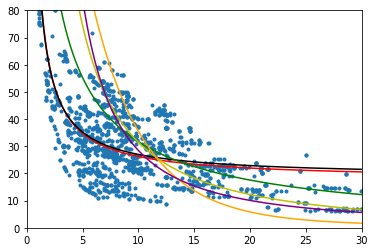

In [132]:
fig = plt.figure()
ax = plt.subplot(111)
_= plt.scatter(x=EROI, y=p, marker = '.')
_= plt.plot(EROI_for_prediction, p_predicted, color='r')
_= plt.plot(EROI_for_prediction, p_woo_predicted, color='black')
_= plt.plot(EROI_for_prediction, np.power(log_p_predicted, 10)-epsilon, color='g')
_= plt.plot(EROI_for_prediction, np.power(log_p_woo_predicted, 10)-epsilon, color='y')
_= plt.plot(EROI_for_prediction, np.power(log_p_loglin_predicted, 10)-epsilon, color='orange')
_= plt.plot(EROI_for_prediction, np.power(log_p_log2_predicted, 10)-epsilon, color='purple')
_= ax.set_xlim(0, 30)
_= ax.set_ylim(0, 80)

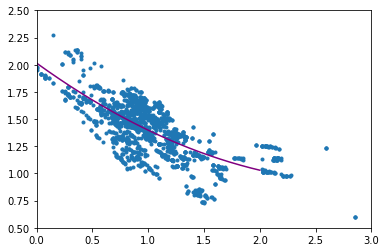

In [133]:
fig = plt.figure()
ax = plt.subplot(111)
_= plt.scatter(log_EROI, log_p, marker='.')
_= plt.plot(log_EROI_for_prediction, log_p_log2_predicted, color='purple')
_= ax.set_xlim(0, 3)
_= ax.set_ylim(0.5, 2.5)

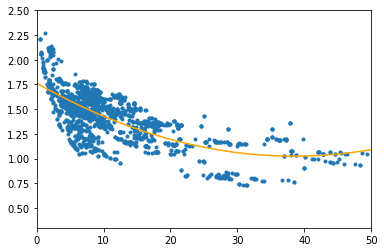

In [134]:
fig = plt.figure()
ax = plt.subplot(111)
_= plt.scatter(EROI, log_p, marker='.')
_= plt.plot(EROI_for_prediction, log_p_loglin_predicted, color='orange')
_= ax.set_xlim(0, 50)
_= ax.set_ylim(0.3, 2.5)

In [163]:
round(themis['ER'][2050].dlr_elec['OECD Europe'][2050]/sum(themis['ER'][2050].dlr_elec['OECD Europe'][2050]), 2)

coal             0.00
gas              0.05
oil              0.00
nuclear          0.00
biomass&Waste    0.10
hydro            0.14
wind offshore    0.13
wind onshore     0.24
solar PV         0.17
geothermal       0.07
solar CSP        0.08
ocean            0.03
Name: 2050, dtype: float64

In [201]:
# themis['ADV'][2050].inputs('electricity, high voltage, production ES, at grid/ ES/ kWh')

In [178]:
themis['ADV'][2050].find('iogas', vec='sector') # 'transmission network, electricity, high voltage/ CH/ km' 'Transmission services of electricity'
# 'transmission network, long-distance/ UCTE/ km'  'battery, LiIo, rechargeable, prismatic, at plant/ GLO/ kg' 
# 'electricity, high voltage, production ES, at grid/ ES/ kWh' 'electricity, high voltage, at grid/ ES/ kWh'
# '   External cabling, grid connection                                     ' 'battery, NiMH, rechargeable, prismatic, at plant/ GLO/ kg'
# 'electricity, hydropower, at pumped storage power plant/ ES/ kWh' 'hydrogen, liquid, at plant/ RER/ kg' 'hydrogen, liquid, membrane cell, at plant/ RER/ kg'

In [179]:
themis['ADV'][2050].find('verhead', vec='sector')

['   External cabling, overhead line     ',
 '   External cabling, overhead line      ',
 '   External cabling, overhead line                                       ',
 '   Infrastructure elements and overhead costs                            ',
 '   External cabling, overhead line   ']

In [4]:
themis['REF'] = dict()
themis['REF'][2050] = themis['BM'][2050].copy(new_name='THEMIS')
themis['REF'][2050].change_mix(path_dlr = path_themis, scenario = 'REF', year = 2050)
# mix_REF50 = themis['REF'][2050].mix_matrix()

<44046x44046 sparse matrix of type '<class 'numpy.float64'>'
	with 1969638 stored elements in Compressed Sparse Column format>

In [145]:
themis['REF'][2050].erois()

wind onshore      7.1
wind offshore     7.7
solar PV          5.2
coal             11.1
oil              11.1
gas              15.4
nuclear           7.0
hydro            11.1
biomass&Waste     5.0
ocean             2.5
geothermal        2.5
solar CSP         7.9
total             7.1
dtype: float64

In [ ]:
themis['BL'][2010].A[42219:44046,:][:,0:42219] # there are 945 non-zeros inputs from background to foreground... # TODO: understand this
themis['BL'][2010].A[themis['BL'][2010].index_secs_regs(themis['BL'][2010].energy_sectors('secondary')),:][:,0:42219] # ... but none of them is energy!

In [36]:
# submatrix_background_to_foreground = themis['BL'][2010].A[42219:44046,:][:,0:42219]
# index_background_inputs_to_foreground = submatrix_background_to_foreground.nonzero()[0]
# index_foreground_output_from_background = submatrix_background_to_foreground.nonzero()[1] # I may have inverted foreground and background in 0/1
# background_inputs_to_foreground = themis['BL'][2010].labels.idx_sectors[[e + 42219 for e in index_background_inputs_to_foreground]].unique()
# foreground_output_from_background = themis['BL'][2010].labels.idx_sectors[index_foreground_output_from_background].unique()
# # background_inputs_to_foreground
# # foreground_output_from_background

In [ ]:
spla.cgs(sp.eye(self.A.shape[0])-self.A, prod, approx_solution(self.A,prod).transpose().toarray()[0], tol=1e-7)[0]

In [83]:
all(themis['BL'][2010].production('   Electricity from IGCC plant                                           ')==0)

True

In [37]:
# all(themis['BL'][2010].embodied_prod('   Electricity from IGCC plant                                           ')==0)
# themis['BL'][2010].inputs('   Electricity from IGCC plant                                           ')

In [38]:
# index_example_from_foreground = inter_secs(themis['BL'][2010].index_secs_regs('   Electricity from IGCC plant                                           '),\
#            index_foreground_output_from_background)
# # index_example_from_foreground
# # themis['BL'][2010].labels.idx_sectors[index_example_from_foreground] # to check if correct
# where_index_from_example = np.where([s in index_example_from_foreground for s in index_foreground_output_from_background])[0]
# # where_index_from_example
# index_foreground_inputs_from_example = index_foreground_output_from_background[where_index_from_example]
# index_foreground_inputs_from_example # to check if correct
# index_background_inputs_from_example = index_background_inputs_to_foreground[where_index_from_example]
# index_background_inputs_from_example
# # submatrix_background_to_foreground[index_background_inputs_from_example,:][:,index_foreground_inputs_from_example].A # check if correct
# background_inputs_from_example = themis['BL'][2010].labels.idx_sectors[[e + 42219 for e in index_background_inputs_from_example]].unique()
# background_inputs_from_example
# themis['BL'][2010].labels.idx_sectors[42219 + index_background_inputs_from_example[0]]
# themis['BL'][2010].labels.idx_sectors[index_foreground_inputs_from_example[0]]
# # themis['BL'][2010].A[[e + 42219 for e in index_background_inputs_from_example],:][:,index_foreground_inputs_from_example].A
# themis['BL'][2010].A[42219 + index_background_inputs_from_example[0], index_foreground_inputs_from_example[0]]

In [41]:
inter_secs(themis['BL'][2010].index_secs_regs('   Electricity from EX PC power plant                                    '), index_foreground_output_from_background)

[121, 725, 1329]

In [81]:
# themis['BL'][2010].inputs('   Electricity from EX PC power plant                                    ', nb_main=100)
# TODO!: why is this in foreground_output_from_background but there is no background inputs in it ?!

In [2]:
path_themis = '/media/adrien/dd1/adrien/DD/Économie/Données/Themis/'
# path_themis = '/media/sf_U_DRIVE/Données/Themis/'

In [3]:
dlr_elec, dlr_heat, dlr_primary_demand, dlr_co2, dlr_h2, dlr_final_demand, regions_dlr, dlr_mix = pickle.load(open(path_themis+'greenpeace_scenarios.pkl', 'rb')) # code at the end

In [4]:
%%capture
themis = pymrio.themis_parser(path_themis)

In [16]:
### impossible to do the steps below because themis doesn't include x nor y
# 1a. obtain energy supply by reg, sec from Z+Y and them separately
# 1b. check mix is the same in both, 
# 1c. compute shares of elec in Z and Y
# 2a. introduce dlr elec mix and apply GRAS to Z and Y
# 2b. recalc x, A, etc.
# 3. compute EROIs
# 4. manage other sectors
# TODO: aggregate world and EROI for 100% of each
# regions_dlr = list(themis['BL'][2010].regions) + ['Africa', 'Middle East', 'World']
# regions_dlr
# themis['BL'][2010].regions
# supply_sec_reg = themis['BL'][2050].energy_supply.dot(themis['BL'][2050].production(sec, reg))

In [17]:
elec_idx = themis['BM'][2050].index_secs_regs(themis['BM'][2050].energy_sectors('electricities'))
themis_dlr_ER_2050 = themis['BM'][2050].copy(new_name='THEMIS')
# themis_dlr_ER_2050.change_mix(dlr_mix['ER'][2050]) 
themis_dlr_ER_2050.change_mix(path_dlr = path_themis, year = 2050)

/home/adrien/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<44046x44046 sparse matrix of type '<class 'numpy.float64'>'
	with 1969638 stored elements in Compressed Sparse Column format>

In [18]:
dlr_ER50_sectors = np.array(themis_dlr_ER_2050.energy_sectors('electricities'))[['CCS' not in s for s in themis_dlr_ER_2050.energy_sectors('electricities')]]
# and 'nuclear' not in s \                                                       
themis_dlr_ER_2050.erois(secs = dlr_ER50_sectors, recompute=True) # why results slightly different in Evolution of EROI.ipynb?
# total is different because CCS not included in dlr_sectors, and for the others maybe because here change_mix(dlr_mix) and there change_mix(dlr_path, year)

/home/adrien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:335: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/adrien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:336: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


wind onshore      7.0
wind offshore     6.0
solar PV          5.6
coal              6.3
oil               3.6
gas               9.1
nuclear           6.8
hydro            12.5
biomass&Waste     5.0
ocean             3.8
geothermal        4.8
solar CSP         2.3
Power sector      6.2
dtype: float64

In [69]:
# 1.5 check REF and BAU are close in terms of elec supply
[themis['BM'][y].energy_supply.dot(themis['BM'][y].production(themis['BM'][y].energy_sectors('electricities'))) for y in [2010, 2030, 2050]]
list(dlr_elec['ER']['World'].sum(axis=0) * TWh2TJ)
[themis['BL'][y].energy_supply.dot(themis['BL'][y].production(themis['BL'][y].energy_sectors('electricities'))) for y in [2010, 2030, 2050]]
list(dlr_elec['REF']['World'].sum(axis=0) * TWh2TJ)

[71110446.0, 98987356.0, 135118182.0]

[81374359.4662319, 120948386.35863313, 177126373.58813673]

[71110446.0, 123078185.0, 164648525.0]

[81374359.4662319, 130519903.60709515, 180393720.8825891]

In [ ]:
# dlr_elec['total'].iloc[:10]
# dlr_elec['ER']['World'][2050]

In [ ]:
themis_dlr_ER_2050_agg = themis_dlr_ER_2050.aggregate(region_agg = 'global', sector_agg='total', inplace=False) # doesn't help to go faster, less 

In [187]:
# # themis_dlr_ER_2050.energy_supply_original = themis_dlr_ER_2050.energy_supply.copy()
# # themis_dlr_ER_2050.supply_filled = themis_dlr_ER_2050.energy_supply.copy()
# unitary_supply = themis_dlr_ER_2050.energy_supply_original
# for i in np.array(elec_idx)[np.where(themis_dlr_ER_2050.energy_supply_original[elec_idx]==0)[0]]:
#     sec_i = themis_dlr_ER_2050.labels.idx_sectors[i]
#     unitary_supply[i] = themis_dlr_ER_2050.energy_supply_original.dot(themis_dlr_ER_2050.is_in(sec_i))/\
#         len(np.where(themis_dlr_ER_2050.energy_supply_original*themis_dlr_ER_2050.is_in(sec_i)!=0)[0]) # TODO: median?

In [14]:
themis['BM'][2050].erois(recompute=True)

/home/adrien/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:335: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/adrien/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:336: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


wind onshore      7.4
wind offshore     6.3
solar PV          5.1
coal             12.6
oil               7.4
gas              20.2
nuclear           7.5
hydro            13.2
coal w CCS        7.2
gas w CCS         9.3
biomass&Waste     5.3
biomass w CCS     4.1
ocean             3.0
geothermal        4.8
solar CSP         1.5
Power sector      7.2
dtype: float64

In [ ]:
# /!\ Origin of energy required by technology in ADV 2050: 80% of fossils
themis['ADV'][2050].energy_required(themis['ADV'][2050].energy_sectors('electricities'), source='secondary_fuels')\
    /themis['ADV'][2050].energy_required(themis['ADV'][2050].energy_sectors('electricities'))
for sec in themis['ADV'][2050].energy_sectors('electricities'):
    print(sec, round(themis['ADV'][2050].energy_required(sec, source='secondary_fuels')/themis['ADV'][2050].energy_required(sec),2)) # proportion of fossils: 80%

In [ ]:
EROI_tot_wo_CSP = dict()
for scenario in scenarios+scenarios_dlr:
    EROI_tot_wo_CSP[scenario] = dict()
    for year in years: 
        EROI_tot_wo_CSP[scenario][year] = themis[scenario][year].neer(dlr_sectors[:11])
EROI_tot_wo_CSP

In [9]:
path_io = '/media/adrien/dd1/adrien/DD/Économie/Données/'
# path_io = '/media/sf_U_DRIVE/Données/'

In [66]:
io = pymrio.load_test().calc_all()

In [25]:
exio1p = pymrio.parse_exiobase1(path=path_io+'Exiobase 1/121016_EXIOBASE_pxp_ita_44_regions_coeff_txt.zip')

In [26]:
exio1p = exio1p.calc_all()

In [24]:
exio2p = pickle.load(open(path_io + 'Exiobase 2.2/exio2p.pkl', 'rb'))

In [ ]:
pickle.dump(exio2p, open(path_io + 'Exiobase 2.2/exio2p.pkl', 'wb'))

In [16]:
path_pxp = path_io + 'Exiobase 2.2/mrIOT_PxP_ita_coefficient_version2.2.2.zip'
exio2p = pymrio.parse_exiobase2(path=path_pxp, charact=True, popvector='exio2')
exio2p.calc_all()
exio2p.y = np.sum(exio2p.Y, axis=1)

In [22]:
%%capture
cecilia = pymrio.cecilia_parser('/var/www/FutureIOT/', system='pxp')

In [178]:
%%capture
themis = pymrio.themis_parser('/media/adrien/dd1/adrien/DD/Économie/Données/Themis/')

In [114]:
# check that proportion of energy supply corresponds
global_mixes_BL = themis['BL'][2010].energy.demand.groupby(level='year', axis=1).sum()
themis['BL'][2010].global_mixes = round(global_mixes_BL/global_mixes_BL.loc['Electricity by total'],2)
themis['BL'][2010].global_mixes = themis['BL'][2010].global_mixes.rename(index={s: s[15:] for s in themis['BL'][2010].global_mixes.index})
global_mixes_BM = themis['BM'][2010].energy.demand.groupby(level='year', axis=1).sum()
themis['BM'][2010].global_mixes = round(global_mixes_BM/global_mixes_BM.loc['Electricity by total'],2)
themis['BM'][2010].global_mixes = themis['BM'][2010].global_mixes.rename(index={s: s[15:] for s in themis['BM'][2010].global_mixes.index})
pd.DataFrame(themis['BM'][2010].global_mixes[2010]).rename(columns={2010: 'EROI'}).join(pd.DataFrame(themis['BM'][2010].erois(), columns=['mix']))

/home/adrien/anaconda3/lib/python3.5/site-packages/pymrio-0.3.6-py3.5.egg/pymrio/tools/iofunctions.py:332: RuntimeWarning: invalid value encountered in double_scalars
  return(round(supply/(embodied - input_fuel),1))


,EROI,mix
coal,0.42,12.6
coal w CCS,0.00,NaN
gas,0.21,13.7
gas w CCS,0.00,NaN
biomass&Waste,0.01,11.3
biomass w CCS,0.00,NaN
oil,0.06,8.2
nuclear,0.14,10.4
hydro,0.16,13.1
ocean,0.00,5.5


In [3]:
cecilia[-1].erois()

wind             1.1
hydro            5.1
coal             8.1
gas              9.1
nuclear         11.6
Power sector     7.9
dtype: float64

In [115]:
themis['BM'][2050].erois()

wind onshore      7.4
wind offshore     6.3
solar PV          5.1
coal             12.6
oil               7.4
gas              20.2
nuclear           7.5
hydro            13.2
coal w CCS        7.2
gas w CCS         9.3
biomass&Waste     5.3
biomass w CCS     4.1
ocean             3.0
geothermal        4.8
solar CSP         1.5
Power sector      7.2
dtype: float64

In [27]:
exio1p.erois() 

wind             1.4
hydro           15.3
coal            14.3
gas             14.3
nuclear         34.6
Power sector    11.5
dtype: float64

In [10]:
exio2p.erois() 

EROI with Total Energy supply from secondary sources at the denominator, unadjusted for growth
wind 14.3
solar photovoltaic 10.0
coal 14.9
petroleum and other oil derivatives 6.2
gas 13.6
nuclear 23.6
hydro 16.8


[14.3, 10.0, 14.9, 6.2, 13.6, 23.6, 16.8]